In [1]:
#Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import word_tokenize
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from transformers import TrainingArguments, Trainer
import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Loading the dataset (if working on Google Colab)
drive.mount('/content/drive')
df_train = pd.read_csv('/content/drive/MyDrive/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/test.csv')
#df_train.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# working on local machine
#os.chdir('/Users/nikhilkudupudi/Projects - School & Work/FAI /Project/Tweet-Classification-for-Disaster-Detection/data')
#print(os.getcwd())

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Exploratory Data Analysis

Let's explore the Target Variable

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


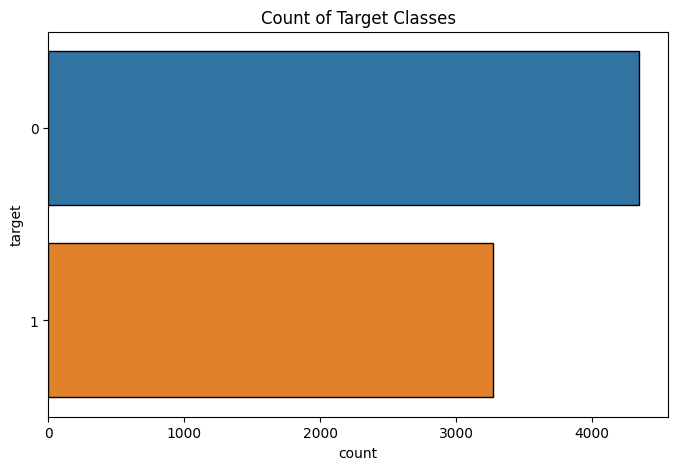

In [6]:
# Visualizing the target classes
plt.figure(figsize=(8,5))
plt.title("Count of Target Classes")
sns.countplot(y=df_train["target"],linewidth=1,
                   edgecolor='black')

plt.show()

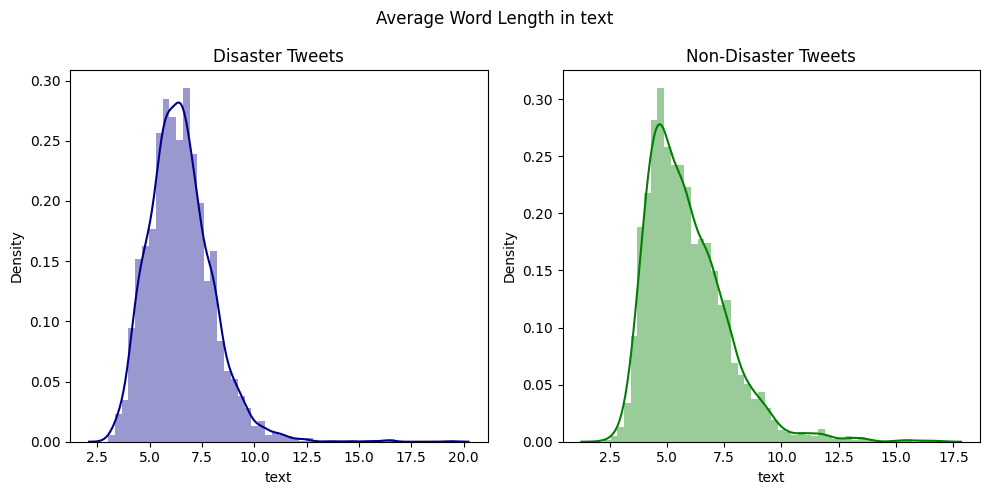

In [7]:
# Analysing average word length in text.

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
char_len_dis = df_train[df_train['target']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_dis.map(lambda x: np.mean(x)),ax=ax1,color='darkblue')
ax1.set_title('Disaster Tweets')
char_len_ndis = df_train[df_train['target']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(char_len_ndis.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Non-Disaster Tweets')
plt.suptitle("Average Word Length in text")
plt.tight_layout()
plt.show()

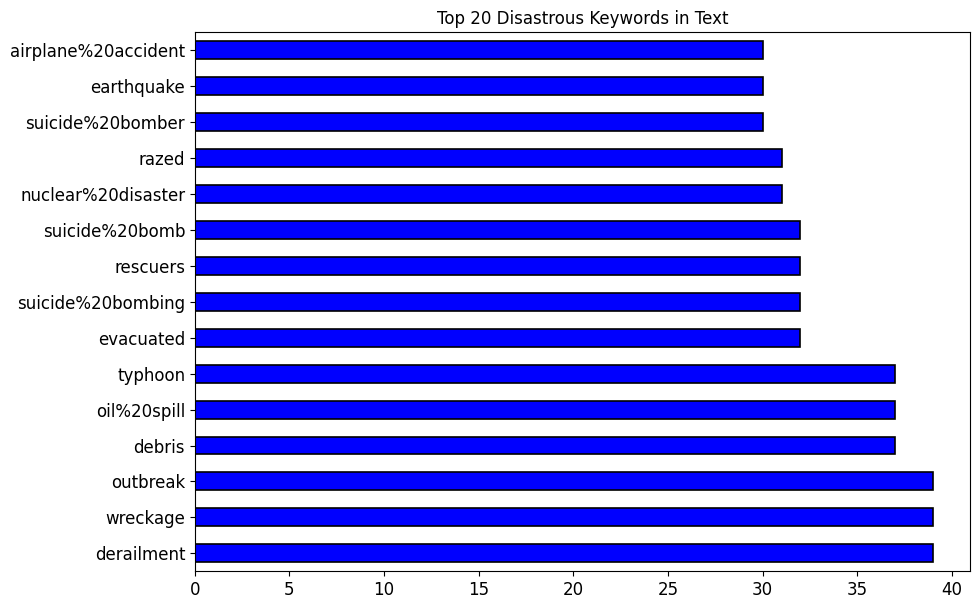

In [8]:
# Analysing Top 20  disastrous KeyWords in text .
plt.figure(figsize=(10,7))
df_train[df_train['target']==1]['keyword'].value_counts()[:15].plot(kind='barh', fontsize=12,title='Top 20 Disastrous Keywords in Text', color='blue',edgecolor='black', linewidth=1.2)
plt.show()

In [9]:
# Summary of the target variable distribution
target_distribution = df_train['target'].value_counts(normalize=True)

# Summary of missing values in the training data
missing_values_train = df_train.isnull().sum()

# Summary of missing values in the test data
missing_values_test = df_test.isnull().sum()

print("Target Distribution:\n")
print(target_distribution)
print()
print("Missing Values in Training set:\n")
print(missing_values_train)
print()
print("Missing Values in Testing set:\n")
print(missing_values_test)

Target Distribution:

0    0.57034
1    0.42966
Name: target, dtype: float64

Missing Values in Training set:

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Testing set:

id             0
keyword       26
location    1105
text           0
dtype: int64


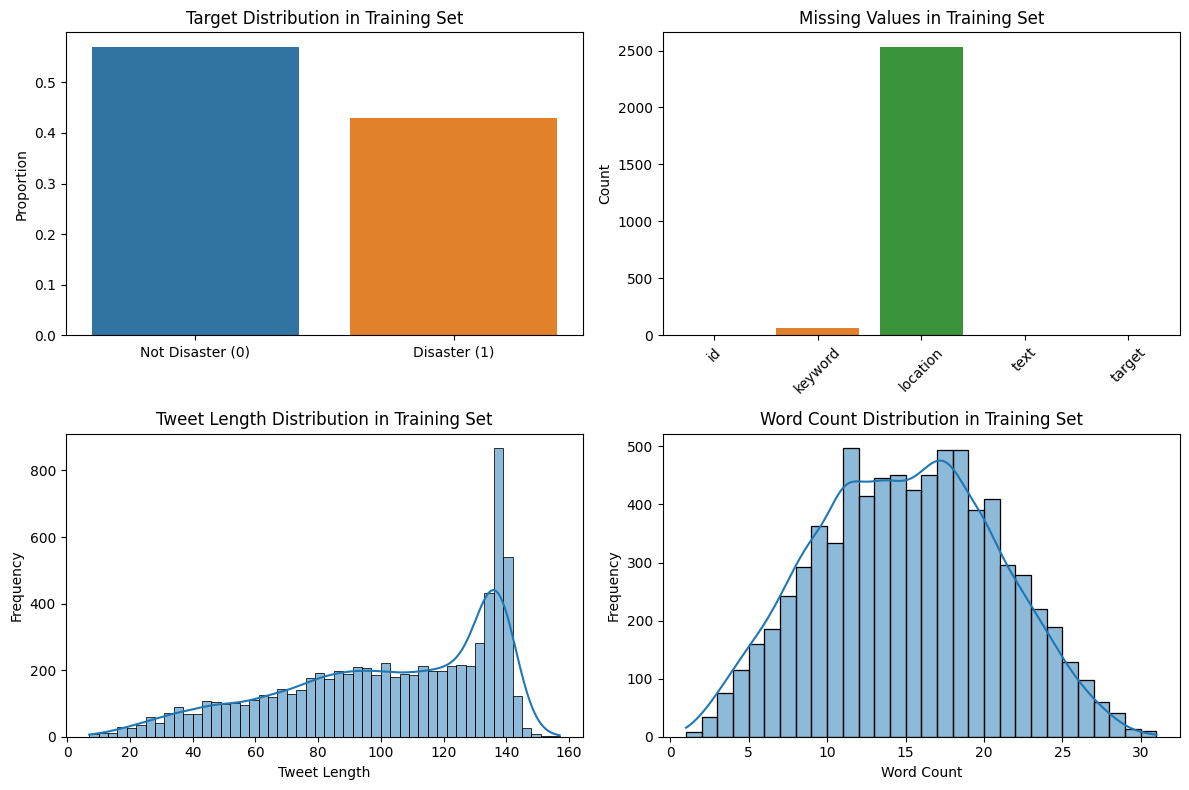

In [10]:
# Distribution of tweet lengths
tweet_length_train = df_train['text'].str.len()
tweet_length_test = df_test['text'].str.len()

# Distribution of number of words in tweets
word_count_train = df_train['text'].apply(lambda x: len(x.split()))
word_count_test = df_test['text'].apply(lambda x: len(x.split()))

# Create a figure to visualize EDA results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Target distribution
sns.barplot(ax=axes[0, 0], x=target_distribution.index, y=target_distribution.values)
axes[0, 0].set_title('Target Distribution in Training Set')
axes[0, 0].set_ylabel('Proportion')
axes[0, 0].set_xticklabels(['Not Disaster (0)', 'Disaster (1)'])

# Missing values in training set
sns.barplot(ax=axes[0, 1], x=missing_values_train.index, y=missing_values_train.values)
axes[0, 1].set_title('Missing Values in Training Set')
axes[0, 1].set_ylabel('Count')
for item in axes[0, 1].get_xticklabels():
    item.set_rotation(45)

# Tweet length distribution
sns.histplot(tweet_length_train, bins=50, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Tweet Length Distribution in Training Set')
axes[1, 0].set_xlabel('Tweet Length')
axes[1, 0].set_ylabel('Frequency')

# Word count distribution
sns.histplot(word_count_train, bins=30, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Word Count Distribution in Training Set')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
# Filling missing values for 'keyword' and 'location' with the string 'unknown'
df_train = df_train[['text','target']]
df_test = df_test[['text']]


# Stopwords list
stop_words = set(stopwords.words('english'))

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK's part-of-speech tags to the format expected by the lemmatizer
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [12]:
df_train.head(10)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


## Sampling to tackle imbalanced dataset

In [13]:
from sklearn.utils import resample

target_1 = df_train.loc[df_train['target'] == 1]
len_target_1 = df_train.loc[df_train['target'] == 1].shape[0]

target_0 = df_train.loc[df_train['target'] == 0]
len_target_0 = df_train.loc[df_train['target'] == 0].shape[0]

print('before downsampling: ',len_target_0,len_target_1)


target_0 = resample(target_0,replace=False,n_samples= len_target_1, random_state=42)

print('after downsampling: ',target_0.shape[0],target_1.shape[0])

before downsampling:  4342 3271
after downsampling:  3271 3271


In [14]:
df = pd.concat([target_0,target_1],ignore_index= True)
df = df.sample(frac=1, random_state=42)
df

,text,target
2877,Beyond all bounds; till inundation rise,0
233,three episodes left the end is nigh,0
2131,Industry Tryna Destroy @MeekMill cause he Expo...,0
4328,#HungerArticles: Nepal: Rebuilding Lives and L...,1
1323,Diageo's CEO stresses that a board revolt at U...,0
...,...,...
3772,Drought fuels bush fires in Jamaica - http://t...,1
5191,Top Stories - Google 4 dead dozens injured in ...,1
5226,incident with injury:I-495 inner loop Exit 31...,1
5390,Suncorp net profit rises to $1.13 billion in w...,1


In [15]:
# Define the emoji pattern
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

# Function to clean the text data
def clean_text(text):

    # Expand contractions
    text = re.sub(r"can\'t", "cannot", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"There's", "There is", text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower().strip()

    # Remove Emoji
    text = emoji_pattern.sub(r'', text)

    # Tokenization and stopwords removal
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Part-of-speech tagging

    pos_tagged = nltk.pos_tag(filtered_tokens)

    # Lemmatization
    lemmatized_text = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tagged]

    return ' '.join(lemmatized_text)

# Cleaning the text column in the dataset
df['text_clean'] = df['text'].apply(clean_text)
df_test['text_clean'] = df_test['text'].apply(clean_text)

In [16]:
# Performing TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df['text_clean'])
X_tfidf = X_tfidf.toarray()

In [17]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, df['target'], test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape)

(5233, 5000) (1309, 5000)


# Model from stratch

In [18]:
import StratchModels

## Naive Bayes' Classifier

In [19]:
# Training the model
nb = StratchModels.MultinomialNaiveBayes()
nb.fit(X_train, y_train)

In [20]:
# Predicting on the validation set
y_pred = nb.predict(X_val)  # Convert sparse matrix to dense

In [21]:
# Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7769289533995416
Precision: 0.827768014059754
Recall: 0.7082706766917293
F1 Score: 0.7633711507293355


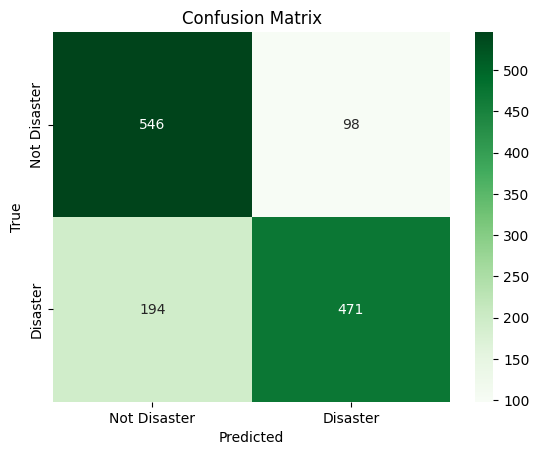

In [22]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print(y_train.shape)

(5233,)


In [24]:
Crossvalidation = StratchModels.CustomCrossValidator(StratchModels.MultinomialNaiveBayes(), 3)
Crossvalidation.fit_and_evaluate(X_train, y_train)

avg accuracy:  0.7804320776705834
avg precision:  0.8300067348076524
avg recall:  0.7033699592907433
avg f1:  0.7611779551279158


{'accuracy': [0.7793696275071633, 0.7889908256880734, 0.7729357798165137],
 'precision': [0.8389355742296919, 0.8223938223938224, 0.8286908077994429],
 'recall': [0.6892980437284235, 0.7353279631760644, 0.6854838709677419],
 'f1': [0.7567909033480733, 0.7764277035236938, 0.7503152585119799]}

## Logistic Regression

In [25]:
lr_model = StratchModels.LogisticRegression()
lr_model.fit(X_train, np.array(np.array(y_train).reshape(-1,1)))

lr_ypred_train = lr_model.predict(X_train)
print('Training Accuracy: ', accuracy_score(np.array(y_train).reshape(-1,1), lr_ypred_train))

Training Accuracy:  0.7018918402446016


In [26]:
lr_ypred_val = lr_model.predict(X_val)

print(classification_report(np.array(y_val).reshape(-1,1),lr_ypred_val))

              precision    recall  f1-score   support

           0       0.61      0.98      0.75       644
           1       0.95      0.38      0.55       665

    accuracy                           0.68      1309
   macro avg       0.78      0.68      0.65      1309
weighted avg       0.78      0.68      0.65      1309



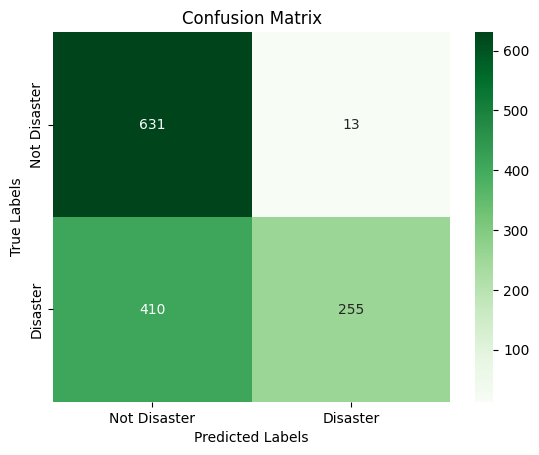

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, lr_ypred_val)
# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
Crossvalidation = StratchModels.CustomCrossValidator(StratchModels.LogisticRegression(), 3)
Crossvalidation.fit_and_evaluate(X_train, np.array(y_train).reshape(-1,1))

avg accuracy:  0.6745661479281125
avg precision:  0.9597106095073843
avg recall:  0.36186295669758306
avg f1:  0.5253690428217673


{'accuracy': [0.6699140401146132, 0.6743119266055045, 0.6794724770642202],
 'precision': [0.9710610932475884, 0.9602446483180428, 0.9478260869565217],
 'recall': [0.3475258918296893, 0.3613348676639816, 0.37672811059907835],
 'f1': [0.5118644067796609, 0.5250836120401338, 0.539159109645507]}

## Random Forest

In [29]:
# Create and train a Random Forest
rf_model = StratchModels.RandomForestClassifier(n_trees=100, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

In [30]:
rf_ypred_train = rf_model.predict(X_train)
print('Training Accuracy: ', accuracy_score(y_train, rf_ypred_train))

Training Accuracy:  0.5629657939996178


In [31]:
rf_ypred_val = rf_model.predict(X_val)

In [32]:
# Evaluation Metrics
accuracy = accuracy_score(rf_ypred_val, y_val)
precision = precision_score(rf_ypred_val, y_val)
recall = recall_score(rf_ypred_val, y_val)
f1 = f1_score(rf_ypred_val, y_val)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.5431627196333079
Precision: 0.12631578947368421
Recall: 0.8316831683168316
F1 Score: 0.21932114882506526


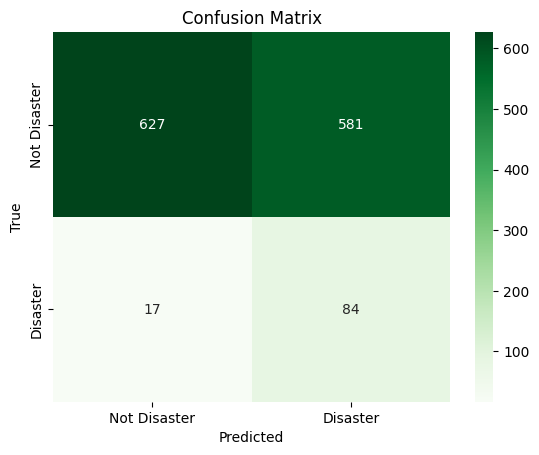

In [33]:
# Confusion Matrix
conf_matrix = confusion_matrix(rf_ypred_val, y_val)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [40]:
Crossvalidation = StratchModels.CustomCrossValidator(StratchModels.RandomForestClassifier( max_depth=3, random_state=42), 3)
Crossvalidation.fit_and_evaluate(X_train, y_train)

avg accuracy:  0.5599078406631441
avg precision:  0.8730955542217614
avg recall:  0.13621957190760783
avg f1:  0.2355047734865606


{'accuracy': [0.5621776504297994, 0.5619266055045872, 0.5556192660550459],
 'precision': [0.8888888888888888, 0.8523489932885906, 0.8780487804878049],
 'recall': [0.1380897583429229, 0.14614499424626007, 0.12442396313364056],
 'f1': [0.23904382470119523, 0.24950884086444008, 0.21796165489404642]}

# LSTM

In [41]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input ,LSTM, Dropout,Flatten,Bidirectional, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping

In [42]:
df_train = df_train[['text', 'target']]
df_train

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [43]:
x_train, x_test, y_train, y_test = train_test_split(df_train['text'], df_train['target'], test_size= 0.2, random_state= 42)

In [45]:
from LSTM_Model.Glove_embeddings import GloveVectorizer

# Download below model from stanford - https://nlp.stanford.edu/projects/glove/
glove_file_path = '/Users/nikhilkudupudi/Projects - School & Work/FAI /Project/Tweet-Classification-for-Disaster-Detection/LSTM_Model/glove.twitter.27B.100d.txt'

print(glove_file_path)
glove_embedder = GloveVectorizer(glove_file_path)

glove_embeddings_array = glove_embedder.vectorize_data(x_test)
glove_embeddings_array.shape

ModuleNotFoundError: ignored

In [ ]:
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred, precision, recall):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)

    f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value + K.epsilon())
    return f1

@tf.function
def compiled_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, precision_metric, recall_metric)

model_path =  '/Users/nikhilkudupudi/Projects - School & Work/FAI /Project/Tweet-Classification-for-Disaster-Detection/LSTM_Model/LSTM_model_Glove100.h5'
Lstm_model = tf.keras.models.load_model(model_path,custom_objects={'compiled_f1_score': compiled_f1_score})

In [ ]:
Lstm_model.summary()

In [ ]:
y_pred = Lstm_model.predict(glove_embeddings_array)
y_pred = (y_pred > 0.5).astype(int)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt='d', cmap='Greens',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## BERT - Bidirectional Encoder Representations from Transformers

In [46]:
!pip install transformers

In [47]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.7 MB/s eta 0:00:00


In [105]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [106]:
# Tokenization and encoding of the dataset
def preprocess_data(data, tokenizer, max_length=64):
    return tokenizer(
        text=data['text_clean'].tolist(),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

# Splitting the data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Apply preprocessing to the split data
encoded_train = preprocess_data(train_df, tokenizer)
encoded_val = preprocess_data(val_df, tokenizer)

In [107]:
class TweetDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create datasets for the new training and validation sets
train_labels = train_df['target'].tolist()
val_labels = val_df['target'].tolist()

train_dataset = TweetDataset(encoded_train, train_labels)
val_dataset = TweetDataset(encoded_val, val_labels)

In [108]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [109]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs'
)

# Instantiate the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

Step,Training Loss
500,0.501400


TrainOutput(global_step=984, training_loss=0.42601517157825997, metrics={'train_runtime': 201.809, 'train_samples_per_second': 77.791, 'train_steps_per_second': 4.876, 'total_flos': 516322557262080.0, 'train_loss': 0.42601517157825997, 'epoch': 3.0})

In [111]:
# Evaluate the model
results = trainer.evaluate()

# Process the predictions to evaluate the model
predictions = trainer.predict(val_dataset)

In [112]:
# Extract logits from the predictions
logits = predictions.predictions

# Apply a softmax to convert logits to probabilities
probabilities = torch.nn.functional.softmax(torch.from_numpy(logits), dim=-1)

# Convert probabilities to actual predictions (0 or 1)
predicted_labels = torch.argmax(probabilities, axis=1).numpy()

In [113]:
# Calculate metrics
accuracy = accuracy_score(val_labels, predicted_labels)
precision = precision_score(val_labels, predicted_labels)
recall = recall_score(val_labels, predicted_labels)
f1 = f1_score(val_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7944996180290298
Precision: 0.8183279742765274
Recall: 0.7654135338345864
F1 Score: 0.7909867909867909


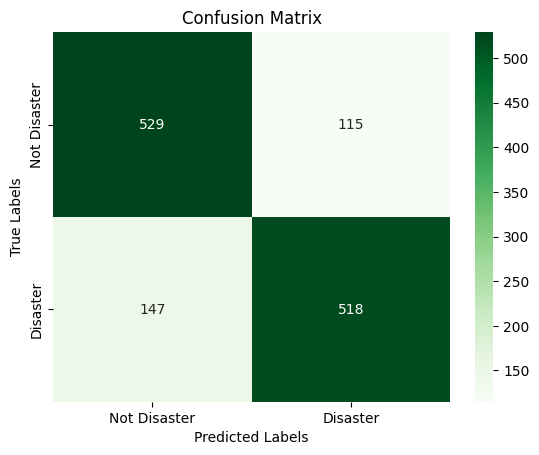

In [69]:
# Confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# XGBOOST CLASSIFIER

In [ ]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(objective= 'binary:logistic',
                          max_depth = 6,
                          n_estimators = 400,
                          learning_rate=0.01,
                          # reg_alpha=1e-5,
                          device = 'gpu')
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
#Training Score
y_train_pred = xgb_model.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.7450793044142939

In [ ]:
#testing Score
y_pred = xgb_model.predict(X_val)
accuracy_score(y_pred, y_val)

0.7097020626432391

In [ ]:
# Evaluation Metrics for tsting
accuracy = accuracy_score(y_pred, y_val)
precision = precision_score(y_pred, y_val)
recall = recall_score(y_pred, y_val)
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7097020626432391
Precision: 0.5293233082706766
Recall: 0.8400954653937948
F1 Score: 0.6494464944649446


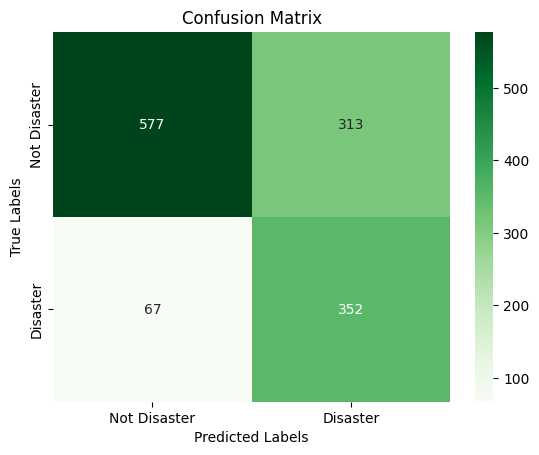

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_pred, y_val)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#cross validation
xgb_model = XGBClassifier(objective= 'binary:logistic',
                          max_depth = 6,
                          n_estimators = 400,
                          learning_rate=0.01,
                          reg_alpha=1e-5,
                          device = 'gpu')


Crossvalidation = StratchModels.CustomCrossValidator(xgb_model, 3)
Crossvalidation.fit_and_evaluate(X_train, y_train)


avg accuracy:  0.6999789700586211
avg precision:  0.84680470973024
avg recall:  0.485407949883246
avg f1:  0.6168636553634754


{'accuracy': [0.710028653295129, 0.7024082568807339, 0.6875],
 'precision': [0.8637274549098196, 0.8352490421455939, 0.8414376321353065],
 'recall': [0.49597238204833144, 0.5017261219792866, 0.45852534562211983],
 'f1': [0.6301169590643275, 0.6268871315600287, 0.5935868754660701]}